Written by Zain Kamal [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu) in 2024 March.

https://github.com/Humboldt-Penguin/redplanet

---
---
Todo:

- ~~[x] decide on a compression/archiving method (`.tar`, `.tar.gz`, `.zip`, etc.)~~
    - ~~=> tar is fastest and compression for others is negligible, HOWEVER `zarr.zipstore` seems pog asf, see footnote 4.~~

- ~~[x] evalute whether i want to use dask zipstore? see footnote 4~~
    - ~~[x] compare load/access speeds between plain zarr dir and zarr.zipstore — so far they seem the same? ...... but that's just experimental, also understand WHY this would be the case (my guess is that zipstore is using compression level 0 as seen in default args here: https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.ZipStore)~~

- ~~[x] once chosen comp/arch method, decide if i want to (a) only store tar and untar + overwrite every time, overwriting untar if necessary, (b) store both tar and untar, trusting that untar is valid (or maybe not?), or (c) delete tar after first untar (somehow?) and store only untar (figure out how to verify untar is correct and not corrupted lmao) ———— time benchmarks will heavily influence decision!~~
    - ~~self note -- leaning towards (b) maybe?~~
    - ~~self note -- potentially useful pooch docs:~~
        - ~~["Unpacking archives"](https://www.fatiando.org/pooch/latest/unpacking.html)~~
        - ~~["pooch.Untar"](https://www.fatiando.org/pooch/latest/api/generated/pooch.Untar.html)~~ 
    - ~~[ ] should i even do hash checks...?~~

---

- big datasets to implement:
    - [ ] zarr-ify weiczorek's topo5287 (load into xarray...? but also have option for raw sh file if user wants it — actually rather than add that to my module, just link to the proper code in a script/notebook somewhere else like a gist or script or colab or something luls)
    - 


- [ ] once zarr dirs are properly archived/compressed, calculate hashes (sha256, md5, and xxh3 for future flexibility) and add to readme fi-WAIT THAT'S NOT POSSIBLE LMAO WTF ——— consider just saying "link to the proper hash can be found here" and maybe link a file in github, or perhaps a github gist lmao


- far future
    - [ ] when i get to maven data, consider a similar dask/zarr chunking approach as here, it's awesome!!! specifically, consider using `polars` -- initial chatgpt convo archived in a few formats below: 
        - [direct link](https://chat.openai.com/share/4369a05c-3860-45bc-a0dd-a7e7f9f9510d)
        - [screenshot](https://files.catbox.moe/kyvlck.png)
        - [export: html](https://files.catbox.moe/u4mh38.html)
        - [export: markdown](https://files.catbox.moe/fcypw5.md)

---
---
# [0] Setup

In [2]:
from redplanet import utils

from pathlib import Path
import zipfile

import pooch

import numpy as np
# import pandas as pd
import pyshtools as pysh

import xarray as xr
import rioxarray
import zarr
# import dask


---
---
# [1] MOLA DEM 463m (Reprojected)

---
## [1.1] Make Zarr Zipstore

<font color='red'>SEE FOOTNOTE 1 & 2</font>

In [2]:
''' ———— Input DEM path (default is to download, use local if you want) ———— '''

with utils.disable_pooch_logger():
    fpath_DEM_463 = pooch.retrieve(
        fname      = 'Mars_MGS_MOLA_DEM_mosaic_global_463m.tif', 
        url        = r'https://drive.google.com/file/d/1ACMocVNzs7pFwxulLOp2vqQ24LjLOVuU/view?usp=sharing', 
        # known_hash = 'sha256:38a4eb0b4452855b8dabfac40a367b458555ab4c01b31235807ad0a53c031f4c', 
        known_hash = 'xxh3_64:a0dc027e687f855f',    ## use sha256 if xxh3 not installed
        # known_hash = None, 
        path       = pooch.os_cache('redplanet') / 'Crust' / 'topo', 
        downloader = utils.download_gdrive_file_SHOWPROGRESS, 
    )


fpath_DEM_463 = Path(fpath_DEM_463) ## customize this if you want



''' —————————————— Load DEM (chunked with dask) and reproject —————————————— '''

# Mars 2000 Sphere CRS, directly taken from the 200m DEM file.
target_crs_wkt = 'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'

dat_dem_xr_463 = (
    rioxarray.open_rasterio(
        filename = fpath_DEM_463, 
        chunks   = {'x': 'auto', 'y': 'auto'}, 
    )
    .rio.reproject(target_crs_wkt)      ## bottleneck (~45sec)
    .chunk({'x': 'auto', 'y': 'auto'})
    .sel(band=1).drop_vars(['band'])
    .rename({'x': 'lon', 'y': 'lat'})
    .sortby('lat', ascending=True)
    .chunk({'lon': 'auto', 'lat': 'auto'})
    .rename('Mars_MGS_MOLA_DEM_463m_v2')
)

dat_dem_xr_463.attrs = {
    'units'       : 'meters', 
    'data_source' : 'https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m', 
    'description' : "Details and source code for modifications made to original DEM can be found at 'github.com/Humboldt-Penguin/redplanet' (search for a file like `chunk_dataset.ipynb`).", 
}

print(f'New CRS info:\n')
utils.print_dict(dat_dem_xr_463.spatial_ref.attrs)
print()
print(f'xarray.DataArray string repr:\n{dat_dem_xr_463}')
print()
print(f'xarray.DataArray html repr (may not fully render in Github):\n')
dat_dem_xr_463

New CRS info:

'crs_wkt'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'semi_major_axis'
	3396190.0
'semi_minor_axis'
	3396190.0
'inverse_flattening'
	0.0
'reference_ellipsoid_name'
	'Mars_2000_Sphere_IAU_IAG'
'longitude_of_prime_meridian'
	0.0
'prime_meridian_name'
	'Reference_Meridian'
'geographic_crs_name'
	'GCS_Mars_2000_Sphere'
'horizontal_datum_name'
	'Mars_2000_(Sphere)'
'grid_mapping_name'
	'latitude_longitude'
'spatial_ref'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'GeoTransform'
	'-180.0 0.007812330461578525 0.0 90.0 0.0 -0.007812060044947162'

xarray.DataArray string repr:
<xarray

<xarray.DataArray 'Mars_MGS_MOLA_DEM_463m_v2' (lat: 23041, lon: 46081)> Size: 2GB
dask.array<rechunk-merge, shape=(23041, 46081), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 369kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 184kB -89.99 -89.99 -89.98 ... 89.98 89.99 90.0
    spatial_ref  int32 4B 0
Attributes:
    units:        meters
    data_source:  https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyo...
    description:  Details and source code for modifications made to original ...

In [3]:
''' ————————————————————————— Save as Zarr ZipStore ———————————————————————— '''

# newdir_463 = Path.cwd()
# newdir_463 = Path(r'C:\Users\Eris\Downloads\marstuff_topo')
newdir_463 = pooch.os_cache('redplanet') / 'Crust' / 'topo'
newpath_463 = newdir_463 / 'Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected' 

# dat_dem_xr_463.to_zarr(newpath_463.with_suffix('.zarr'))
# dat_dem_xr_463.to_netcdf(newpath_463.with_suffix('.nc'))

with zarr.ZipStore(newpath_463.with_suffix('.zarr.zip'), mode='w') as zipstore_463:
    dat_dem_xr_463.to_zarr(store=zipstore_463)






''' ————————————————————————————— Write README ————————————————————————————— '''


readme_text_463 = '''README for `Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr.zip`

Created by Zain Kamal in March 2024. Feel free to contact zain.eris.kamal@rutgers.edu with questions. 

NOTE: YOU DO NOT NEED TO UNZIP A `.zarr.zip` FILE TO ACCESS THE DATA — the original zipped file is perfectly usable on its own, and unzipping will just take up more space on your computer. If you're curious about the reasoning, read the bullet points below. 
    - One of the storage classes for Zarr arrays/groups is a `zarr.storage.ZipStore` (https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.ZipStore) which does NOT compress files by default (you can verify this for yourself by unzipping and comparing file sizes). This is very similar to how '.tar' files work, if you're familiar. 
    - We use zipstores because (1) `redplanet` downloads data with `pooch.retrieve` which can only download one file at a time and must always keep the zipped version, and (2) accessing zipstores for a dataset of this size/type/structure has near-zero performance impact compared to a normal Zarr directory. 

For the code used to generate this data, go to https://github.com/Humboldt-Penguin/redplanet and look for a file along the lines of `chunk_dataset.ipynb`. Alternatively, download my Python package with `pip install redplanet` for user-friendly downloading/accessing. 

Original data source: https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m

We modify the original DEM by reprojecting to CRS 'Mars_2000_(Sphere)' (WKT pulled directly from USGS's 200m DEM), chunking with `dask`, and saving as a Zarr ZipStore. Primary benefits are reducing file size from 2GB to 1GB, decreasming memory usage, and significantly increasing load/access speeds (by several orders of magnitude, especially since reprojecting takes ~30 seconds every time). 

To load this data, use the following code:

```python

import xarray as xr
import rioxarray    ## optional to attribute/use CRS info -- if you remove this, also remove the `rio.write_crs` lines below.

dat_dem_xr_463 = xr.open_zarr('Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected.zarr.zip')  ## specify path as necessary

## Note that `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable ('Mars_MGS_MOLA_DEM_463m_v2') is the desired DEM data, and the second data variable ('spatial_ref') is the CRS info from reprojection. We want our final data as an `xarray.DataArray`, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
dat_dem_xr_463 = (
    dat_dem_xr_463
    .Mars_MGS_MOLA_DEM_463m_v2
    .rio.write_crs(
        dat_dem_xr_463.spatial_ref.crs_wkt
    )
)

_ = dat_dem_xr_463.attrs.pop('grid_mapping', None)

```
'''



# with open(newpath_463.with_suffix('.zarr') / '_README.txt', 'w') as file:
#     file.write(readme_text_463)

with zipfile.ZipFile(newpath_463.with_suffix('.zarr.zip'), 'a') as zipf:
    zipf.writestr('_README.txt', readme_text_463)


In [4]:
''' ——————————————————————————— hashes for pooch ——————————————————————————— '''

fpath_463_zipstore = newpath_463.with_suffix('.zarr.zip')

print(f"xxh3_64:{pooch.file_hash(fpath_463_zipstore, alg='xxh3_64')}")
print(f"sha256:{ pooch.file_hash(fpath_463_zipstore, alg='sha256' )}")
print(f"md5:{    pooch.file_hash(fpath_463_zipstore, alg='md5'    )}")

xxh3_64:ceac119856a5a354
sha256:e58c1198b805fa52149d8bfbc0253dbb4f97bfa1a2c3ccf34c0a3cd2b58e77db
md5:b6a409b8144864fdfd8d6b90ae8f0173


---
## [1.2] Verify

In [3]:
''' ———————————————————————————— load to xarray ———————————————————————————— '''

newdir_463 = pooch.os_cache('redplanet') / 'Crust' / 'topo'
newpath_463 = newdir_463 / 'Mars_MGS_MOLA_DEM_mosaic_global_463m_reprojected' 

dat_dem_xr_463 = xr.open_zarr(newpath_463.with_suffix('.zarr.zip'))

## The following line is needed since `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable 'Mars_MGS_MOLA_DEM_463m_v2' is the desired DEM data, but the other data variable 'spatial_ref' is the CRS info from reprojection. We want our final data as an `xarray.DataArray` for convenience, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
dat_dem_xr_463 = (
    dat_dem_xr_463
    .Mars_MGS_MOLA_DEM_463m_v2
    .rio.write_crs(
        dat_dem_xr_463.spatial_ref.crs_wkt
    )
)

_ = dat_dem_xr_463.attrs.pop('grid_mapping', None)

dat_dem_xr_463

<xarray.DataArray 'Mars_MGS_MOLA_DEM_463m_v2' (lat: 23041, lon: 46081)> Size: 2GB
dask.array<open_dataset-Mars_MGS_MOLA_DEM_463m_v2, shape=(23041, 46081), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 184kB -89.99 -89.99 -89.98 ... 89.98 89.99 90.0
  * lon          (lon) float64 369kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    spatial_ref  int32 4B 0
Attributes:
    data_source:  https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyo...
    description:  Details and source code for modifications made to original ...
    units:        meters

In [9]:
lon_spacing = np.unique(np.diff(dat_dem_xr_463.lon.values))
lat_spacing = np.unique(np.diff(dat_dem_xr_463.lat.values))

print(f'{lon_spacing = }')
print(f'{lat_spacing = }')

lon_spacing = array([0.00781233, 0.00781233, 0.00781233, 0.00781233])
lat_spacing = array([0.00781206, 0.00781206, 0.00781206, 0.00781206])


region.mean().values.item() = -720.5879141384048
region.values.shape = (23041, 46081)


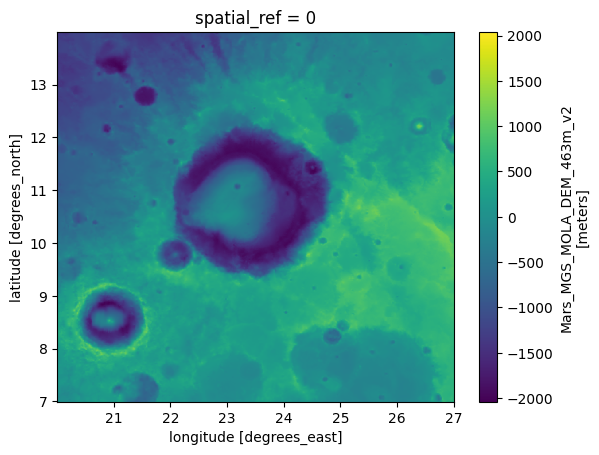

In [6]:
''' —————————————————————————————— test access ————————————————————————————— '''

lon_bounds = (-180, 180)
lat_bounds = (-90, 90)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr_463.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr_463.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


print(f'{region.mean().values.item() = }')
print(f'{region.values.shape = }')





''' ——————————————————————————————— test plot —————————————————————————————— '''

lon_bounds = (20, 27)
lat_bounds = (7, 14)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr_463.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr_463.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


region.plot.imshow(cmap='viridis')

---
---
# [2] MOLA DEM 200m

- Source: (https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2)

---
## [2.1] Make Zarr

In [7]:
''' —————————— Input DEM path (must be local, see above for link) —————————— '''

fpath_DEM_200 = Path(r'C:\Users\Eris\AppData\Local\redplanet\redplanet\Cache\Crust\topo\Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.tif') ## customize this if you want

# if pooch.file_hash(fpath_custom_DEM_200, alg='sha256') != 'e8bfe4c3b9dee9d5fdb8c4d49798869654e552e7b154712c9e12d6d117464419':
#     raise ValueError('WARNING: File hash does not match. You may be using the wrong file, or the file has been modified. Consider trying to download the file again.')


''' ————————————————————— Load DEM (chunked with dask) ————————————————————— '''

dat_dem_xr_200 = (
    rioxarray.open_rasterio(
        filename = fpath_DEM_200, 
        chunks   = {'x': 'auto', 'y': 'auto'}, 
    )
    .sel(band=1).drop_vars(['band'])
    .rename({'x': 'lon', 'y': 'lat'})
    .sortby('lat', ascending=True)
    .chunk({'lon': 'auto', 'lat': 'auto'})
    .rename('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2')
)

dat_dem_xr_200.attrs = {
    'units'       : 'meters', 
    'data_source' : 'https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp', 
    'description' : "Details and source code for modifications made to original DEM can be found at 'github.com/Humboldt-Penguin/redplanet' (search for a file like `chunk_dataset.ipynb`).", 
}

print(f'CRS info (unchanged from source TIF):\n')
utils.print_dict(dat_dem_xr_200.spatial_ref.attrs)
print()
print(f'xarray.DataArray string repr:\n{dat_dem_xr_200}')
print()
print(f'xarray.DataArray html repr (may not fully render in Github):\n')
dat_dem_xr_200

CRS info (unchanged from source TIF):

'crs_wkt'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'semi_major_axis'
	3396190.0
'semi_minor_axis'
	3396190.0
'inverse_flattening'
	0.0
'reference_ellipsoid_name'
	'Mars_2000_Sphere_IAU_IAG'
'longitude_of_prime_meridian'
	0.0
'prime_meridian_name'
	'Reference_Meridian'
'geographic_crs_name'
	'GCS_Mars_2000_Sphere'
'horizontal_datum_name'
	'Mars_2000_(Sphere)'
'grid_mapping_name'
	'latitude_longitude'
'spatial_ref'
	'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
'GeoTransform'
	'-180.0 0.003374120830641 0.0 90.0 0.0 -0.003374120830641'

xarray.DataArray st

<xarray.DataArray 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' (lat: 53347,
                                                             lon: 106694)> Size: 11GB
dask.array<rechunk-merge, shape=(53347, 106694), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 854kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 427kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
    spatial_ref  int32 4B 0
Attributes:
    units:        meters
    data_source:  https://astrogeology.usgs.gov/search/map/Mars/Topography/HR...
    description:  Details and source code for modifications made to original ...

In [8]:
''' ————————————————————————— Save as Zarr ZipStore ———————————————————————— '''


# newdir_200 = Path.cwd()
# newdir_200 = Path(r'C:\Users\Eris\Downloads\marstuff_topo')
newdir_200 = pooch.os_cache('redplanet') / 'Crust' / 'topo'
newpath_200 = newdir_200 / 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' 

# dat_dem_xr_200.to_zarr(newpath_200.with_suffix('.zarr'))
# dat_dem_xr_200.to_netcdf(newpath_200.with_suffix('.nc'))

with zarr.ZipStore(newpath_200.with_suffix('.zarr.zip'), mode='w') as zipstore_200:
    dat_dem_xr_200.to_zarr(store=zipstore_200)





''' ————————————————————————————— Write README ————————————————————————————— '''


readme_text_200 = '''README for `Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.zarr.zip`

Created by Zain Kamal in March 2024. Feel free to contact zain.eris.kamal@rutgers.edu with questions. 

NOTE: YOU DO NOT NEED TO UNZIP A `.zarr.zip` FILE TO ACCESS THE DATA — the original zipped file is perfectly usable on its own, and unzipping will just take up more space on your computer. If you're curious about the reasoning, read the bullet points below. 
    - One of the storage classes for Zarr arrays/groups is a `zarr.storage.ZipStore` (https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.ZipStore) which does NOT compress files by default (you can verify this for yourself by unzipping and comparing file sizes). This is very similar to how '.tar' files work, if you're familiar. 
    - We use zipstores because (1) `redplanet` downloads data with `pooch.retrieve` which can only download one file at a time and must always keep the zipped version, and (2) accessing zipstores for a dataset of this size/type/structure has near-zero performance impact compared to a normal Zarr directory. 

For the code used to generate this data, go to https://github.com/Humboldt-Penguin/redplanet and look for a file along the lines of `chunk_dataset.ipynb`. Alternatively, download my Python package with `pip install redplanet` for user-friendly downloading/accessing. 

Original data source: https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2

Original DEM.tif file is unmodified, except chunking with `dask` and saving as a Zarr ZipStore. Primary benefits are reducing file size from 10GB to 5GB, decreasming memory usage, and significantly increasing load/access speeds (by several orders of magnitude, especially since reprojecting takes ~30 seconds every time). 

To load this data, use the following code:

```python

import xarray as xr
import rioxarray    ## optional to attribute/use CRS info -- if you remove this, also remove the `rio.write_crs` lines below.

dat_dem_xr_200 = xr.open_zarr('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.zarr.zip')  ## specify path as necessary

## Note that `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable ('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2') is the desired DEM data, and the second data variable ('spatial_ref') is the CRS info from reprojection. We want our final data as an `xarray.DataArray`, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
dat_dem_xr_200 = (
    dat_dem_xr_200
    .Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2
    .rio.write_crs(
        dat_dem_xr_200.spatial_ref.crs_wkt
    )
)

_ = dat_dem_xr_200.attrs.pop('grid_mapping', None)

```
'''



# with open(newpath_200.with_suffix('.zarr') / '_README.txt', 'w') as file:
#     file.write(readme_text_200)

with zipfile.ZipFile(newpath_200.with_suffix('.zarr.zip'), 'a') as zipf:
    zipf.writestr('_README.txt', readme_text_200)


---
## [2.2] Verify

In [9]:
''' ———————————————————————————— load to xarray ———————————————————————————— '''

newdir_200 = pooch.os_cache('redplanet') / 'Crust' / 'topo'
newpath_200 = newdir_200 / 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' 

dat_dem_xr_200 = xr.open_zarr(newpath_200.with_suffix('.zarr.zip'))

## Note that `xarray.open_zarr` returns an `xarray.Dataset`. The first data variable ('Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2') is the desired DEM data, and the second data variable ('spatial_ref') is the CRS info from reprojection. We want our final data as an `xarray.DataArray`, and we want to move the 'spatial_ref' to coordinate for rioxarray compliance.
dat_dem_xr_200 = (
    dat_dem_xr_200
    .Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2
    .rio.write_crs(
        dat_dem_xr_200.spatial_ref.crs_wkt
    )
)

_ = dat_dem_xr_200.attrs.pop('grid_mapping', None)

dat_dem_xr_200

<xarray.DataArray 'Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2' (lat: 53347,
                                                             lon: 106694)> Size: 11GB
dask.array<open_dataset-Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2, shape=(53347, 106694), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 427kB -90.0 -89.99 -89.99 ... 89.99 89.99 90.0
  * lon          (lon) float64 854kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    spatial_ref  int32 4B 0
Attributes:
    data_source:  https://astrogeology.usgs.gov/search/map/Mars/Topography/HR...
    description:  Details and source code for modifications made to original ...
    units:        meters

region.mean().values.item() = -720.7675211572935
region.values.shape = (53347, 106694)


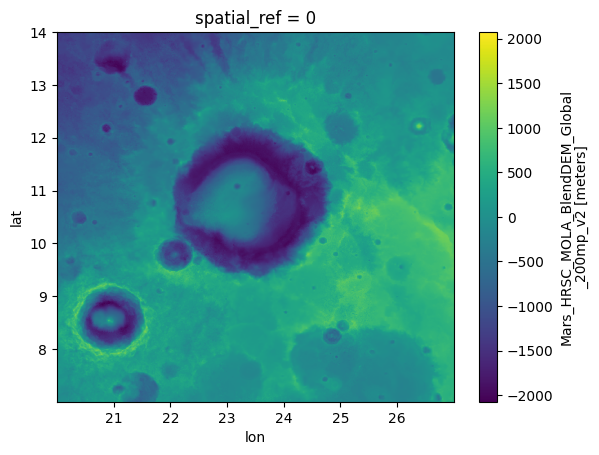

In [10]:
''' —————————————————————————————— test access ————————————————————————————— '''

lon_bounds = (-180, 180)
lat_bounds = (-90, 90)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr_200.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr_200.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


print(f'{region.mean().values.item() = }')
# print(f'{region.values.shape = }')    ## don't do this lol it takes a few minutes, the final shape is (53347, 106694) if you wanna know but you can just check the lon/lat dim sizes





''' ——————————————————————————————— test plot —————————————————————————————— '''

lon_bounds = (20, 27)
lat_bounds = (7, 14)

grid_spacing = 0        # native res

if grid_spacing == 0:
    region = dat_dem_xr_200.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    region = dat_dem_xr_200.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )


region.plot.imshow(cmap='viridis')

In [11]:
''' ——————————————————————————— hashes for pooch ——————————————————————————— '''

fpath_200_zipstore = newpath_200.with_suffix('.zarr.zip')

print(f"xxh3_64:{pooch.file_hash(fpath_200_zipstore, alg='xxh3_64')}")
print(f"sha256:{ pooch.file_hash(fpath_200_zipstore, alg='sha256' )}")
print(f"md5:{    pooch.file_hash(fpath_200_zipstore, alg='md5'    )}")

xxh3_64:d3e3f65f32623481
sha256:a741c5c542e2b41a25ed5b71f0b142e1e515c40600fe9f72f05c7ed625192318
md5:239f022bb5fea42fcb2b774009673ffc


---
---
---
# [-1] FOOTNOTES

---
## [Footnote 1] — Reprojection CRS

When reprojecting the 463m DEM (since native units are x and y in meters I think), we use the CRS WKT straight from the 200m DEM file (stored in the `target_crs_wkt` variable, in case you (a) want to reproject without downloading the entire 200m file, (b) don't see an incentive for me to lie about this /or/ trust that I wouldn't lie, and (c) trust I can copy-paste text properly).

<!-- &nbsp; -->

...

<!-- &nbsp; -->

Main CRS attrs for each DEM (straight from the TIF downloaded from USGS):
- 200m DEM (https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp):
    - 'GeoTransform'
        - '-180.0 0.003374120830641 0.0 90.0 0.0 -0.003374120830641'
    - 'crs_wkt'
        - 'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'
- 463m DEM (https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2)
    - 'GeoTransform'
        - '-10669675.197320545 463.0935415503709 0.0 5334837.598660273 0.0 -463.0935415503709'
    - 'crs_wkt'
        - 'PROJCS["Equirectangular Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars_localRadius",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

---
## [Footnote 2] — Alternative reprojection method with `rasterio` WarpedVRT

Note: when it comes to reprojecting the 463m DEM, here's another code implementation that yields identical results and loads instantly (although I assume speed is lost when calculations are done on the fly). The code is pretty rough (and probably missing some things), but should be fairly easy to adapt if the need arises.

&nbsp;

```python
import rasterio

target_crs_wkt = 'GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'

# vrt = rasterio.vrt.WarpedVRT(rasterio.open(custom_DEM_fpath), crs=target_crs_wkt)
dat_dem_xr_v1 = (
    rioxarray.open_rasterio(
        filename = rasterio.vrt.WarpedVRT(
            src_dataset = rasterio.open(fpath_custom_DEM), 
            crs         = target_crs_wkt, 
        ), 
        chunks = {'x': 'auto', 'y': 'auto'}, 
    )
    .sel(band=1).drop_vars(['band', 'spatial_ref'])
    .rename({'x': 'lon', 'y': 'lat'})
    .sortby('lat', ascending=True)
)


dat_dem_xr_v1
```